In [17]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from tqdm import tqdm
from torch.utils.data import DataLoader
from Yolo_model import Yolov1, test
from VOC_Dataset import VOCDataset
from Dataset_new import VOCDataset_new
from utils import(
    intersection_over_union,
    non_max_suppression,
    mean_average_precision,
    cellboxes_to_boxes,
    get_bboxes,
    plot_image,
    save_checkpoint,
    load_checkpoint,
)
from Yolo_loss import YoloLoss
from Compose_mod import Compose, Composeprime
from torchvision.models import resnet50, ResNet50_Weights
import time
import sys
from torchsummary import summary
import torchvision.transforms as T
import random

In [3]:
seed = 123
torch.manual_seed(seed)

In [45]:
#Hyperparameters etc.
Learning_rate = 1e-3
Device = "cpu"
Batch_size = 16
Weight_decay = 0
epochs = 200
Num_workers = 0
pin_memory = True
load_model = True
load_model_file = "overfit.pth.tar"
img_dir = "/Users/laksh/.keras/datasets/Small_indoor/"
label_dir = "/Users/laksh/Dataset/labels/"

In [24]:
# class Compose(object):
#     def __init__(self, transforms):
#         self.transforms = transforms
        
#     def __call__(self, img, bboxes):
#         for t in self.transforms:
#             img, bboxes = t(img), bboxes
            
#         return img, bboxes

In [5]:
class RandomFlip(object):
    def __init__(self, p=0.5):
        self.p = p
        
    def __call__(self,img, bboxes):
        if random.random() < self.p:
            img =  T.RandomHorizontalFlip(p=1)(img)
            bboxesp = []
            for box in bboxes:
                box = box.tolist()
                box[1] = 1-box[1]
                bboxesp.append(box)
            bboxes = torch.tensor(bboxesp)
        return img, bboxes

In [6]:
transform = Compose([transforms.Resize((448,448)), transforms.ToTensor(), transforms.GaussianBlur(kernel_size=(7, 13), sigma=(0.25, 2)),transforms.ColorJitter(brightness=(0.5,1.5),contrast=(1),saturation=(0.5,1.5),hue=(-0.1,0.1))])

In [7]:
transformprime = Composeprime([RandomFlip()])

In [8]:
def train_fn(train_loader,model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave = True)
    mean_loss=[]
    
    for batch_idx, (x,y) in enumerate(loop):
        x,y = x.to(Device), y.to(Device)
        out = model(x)
        loss = loss_fn(out,y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loop.set_postfix(loss= loss.item())
    
    print("Mean loss was " + str(sum(mean_loss)/len(mean_loss)))

$MODEL$ $ CREATION$

In [9]:
S=7
B=2
C=7

In [10]:
class CNNBlock(nn.Module):
    def __init__(self,in_channels,out_channels,**kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias = False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1) 
        
    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))

In [96]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = False
newmodel = torch.nn.Sequential(*(list(model.children())[:-3]))

In [97]:
summary(newmodel,(3,448,448))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           9,408
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
         MaxPool2d-4         [-1, 64, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]           4,096
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]          36,864
       BatchNorm2d-9         [-1, 64, 112, 112]             128
             ReLU-10         [-1, 64, 112, 112]               0
           Conv2d-11        [-1, 256, 112, 112]          16,384
      BatchNorm2d-12        [-1, 256, 112, 112]             512
           Conv2d-13        [-1, 256, 112, 112]          16,384
      BatchNorm2d-14        [-1, 256, 1

In [98]:
newmodel.fc = nn.Sequential(
    CNNBlock(1024,512,kernel_size=3,stride=1,padding=1),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    CNNBlock(512,512,kernel_size=3,stride=1,padding=1),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    CNNBlock(512,512,kernel_size=3,stride=1,padding=1),
    nn.Flatten(),
    nn.Linear(512*S*S, 496),
    nn.Dropout(0),
    nn.LeakyReLU(0.1),
    nn.Linear(496, S*S*(C+(B*5))), #(S,S,30) where C+B*5 = 30
)

In [99]:
summary(newmodel,(3,448,448))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           9,408
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
         MaxPool2d-4         [-1, 64, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]           4,096
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]          36,864
       BatchNorm2d-9         [-1, 64, 112, 112]             128
             ReLU-10         [-1, 64, 112, 112]               0
           Conv2d-11        [-1, 256, 112, 112]          16,384
      BatchNorm2d-12        [-1, 256, 112, 112]             512
           Conv2d-13        [-1, 256, 112, 112]          16,384
      BatchNorm2d-14        [-1, 256, 1

In [14]:
labelmap = {}
labelmap['exit']=1
labelmap['fireextinguisher']=2
labelmap['chair']=3
labelmap['trashbin']=4
labelmap['screen']=5
labelmap['printer']=6
labelmap['clock']=0

In [48]:
def main():
    
    model = newmodel.to(Device)
    optimizer = optim.Adam(
        model.parameters(), lr = Learning_rate, weight_decay = Weight_decay
    )
    loss_fn = YoloLoss(C=7)
    
    if load_model:
        load_checkpoint(torch.load(load_model_file), model, optimizer)
        
    train_dataset = VOCDataset_new(
        labelmap,
        "/Users/laksh/.keras/datasets/Small_indoor/Book1.csv",
        transform = Compose([transforms.Resize((448,448)), transforms.ToTensor()]),
        transformprime = transformprime,
        img_dir = img_dir,
    )
    
    test_dataset = VOCDataset(
        "/Users/laksh/Dataset/test.csv",
        transform = transform,
        img_dir = img_dir,
        label_dir = label_dir,
    )
    
    train_loader = DataLoader(
        dataset = train_dataset,
        batch_size = Batch_size,
        num_workers = Num_workers,
        pin_memory = pin_memory,
        shuffle = True,
        drop_last = False,
    )
    
    test_loader = DataLoader(
        dataset = test_dataset,
        batch_size = Batch_size,
        num_workers = Num_workers,
        pin_memory = pin_memory,
        shuffle = True,
        drop_last = False,
    )
    
    for epoch in range(epochs):
        print(epoch)
        for x, y in train_loader:
            x= x.to(Device)
            for idx in range(8):
                bboxes = cellboxes_to_boxes(model(x))
                bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4)
                plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)
            import sys
            sys.exit()
            
        pred_boxes, target_boxes = get_bboxes(
            train_loader, model, iou_threshold=0.5, threshold=0.4, device=Device
        )
        
        mean_avg_prec = mean_average_precision(
            pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=7
        )
        
        
        print(mean_avg_prec)
        
        if mean_avg_prec.item()>0.85:
            checkpoint = {
                "state_dict" : model.state_dict(),
                "optimizer" : optimizer.state_dict(),
            }
            save_checkpoint(checkpoint, filename=load_model_file)
            sys.exit()
        
        train_fn(train_loader, model, optimizer, loss_fn)
        
    if __name__== "__main__":
        main()

=> Loading checkpoint
0


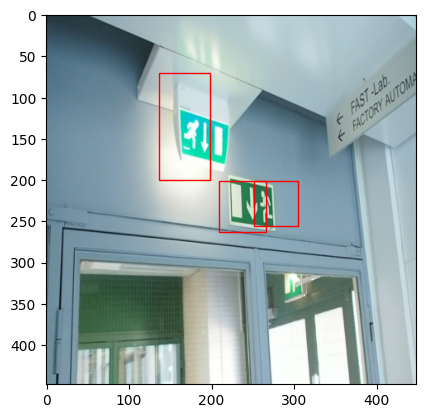

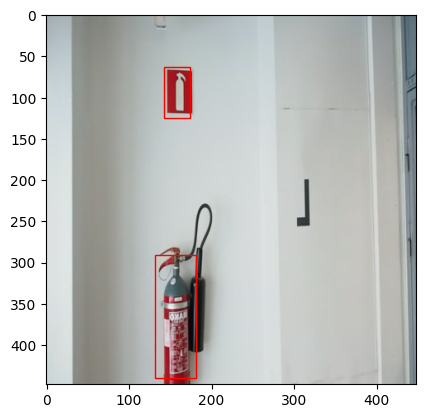

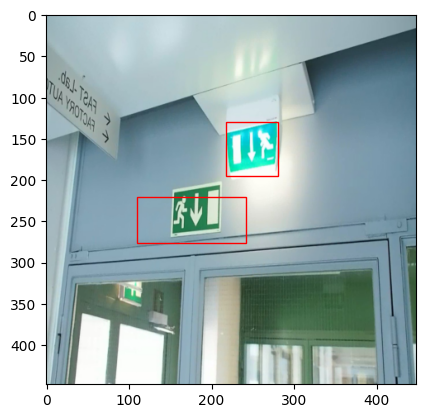

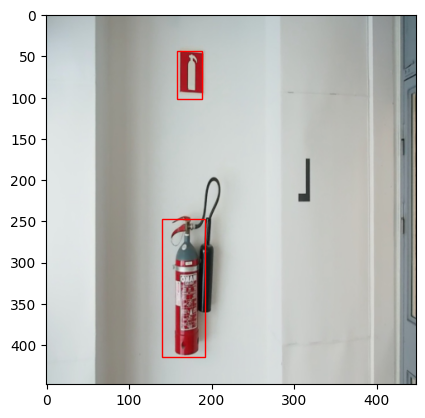

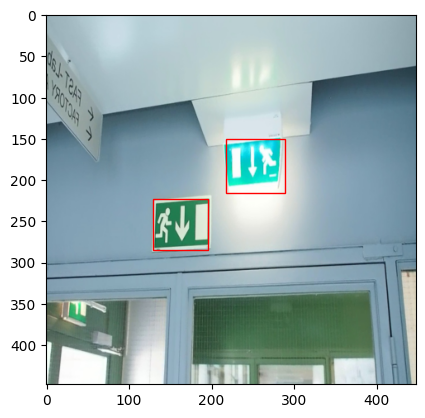

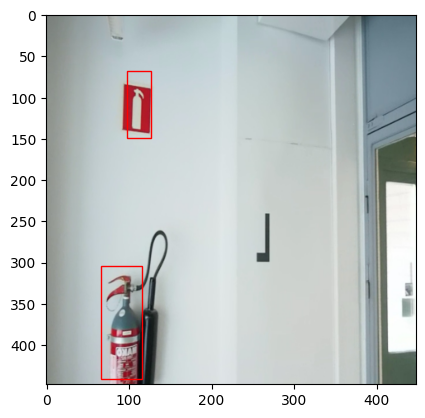

IndexError: list index out of range

In [49]:
main()